In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import time
import scipy.io as io
import os
from os import listdir
import glob
import time
import multiprocessing
from joblib import Parallel, delayed
import shutil
from scipy.signal import find_peaks
import csv

def estimateTimePoints(length,speed,peaks,leftBound,rightBound,th = 0.7,register=0):
    A_list = []
    B_list = []
    C_list = []
    D_list = []
    E_list = []
    F_list = []
    J_list = []
    I_list = []
   
    for ii in range(len(leftBound)):
        if leftBound[ii]<5 or rightBound[ii]>len(speed):
            continue
        maxV = np.max(speed[leftBound[ii]:rightBound[ii]])
        minV = np.min(speed[leftBound[ii]:rightBound[ii]])       
        pos_ind = peaks[ii]+np.argmax(speed[peaks[ii]:rightBound[ii]])
        neg_ind = leftBound[ii]+np.argmin(speed[leftBound[ii]:peaks[ii]])
        A_ind = leftBound[ii]+np.argmin(np.abs(minV*th-speed[leftBound[ii]:neg_ind]))
        C_ind = neg_ind+np.argmin(np.abs(minV*th-speed[neg_ind:pos_ind]))
        
        D_ind = neg_ind+np.argmin(np.abs(maxV*th-speed[neg_ind:pos_ind]))
        F_ind = pos_ind+np.argmin(np.abs(maxV*th-speed[pos_ind:rightBound[ii]]))
        
        length_min = length[peaks[ii]]
        length_base = np.percentile(length[leftBound[ii]:rightBound[ii]],95)
        
        dH = length_base-length_min
        
        I_ind = peaks[ii]+np.argmin(np.abs(dH*th-(length[peaks[ii]:rightBound[ii]]-length_min)))
        
        A_list.append(A_ind)
        B_list.append(neg_ind)
        C_list.append(C_ind)
        D_list.append(D_ind)
        E_list.append(pos_ind)
        F_list.append(F_ind)
        J_list.append(peaks[ii])
        I_list.append(I_ind)
        
    
    As = np.array(A_list)
    Bs = np.array(B_list)
    Cs = np.array(C_list)
    Ds = np.array(D_list)
    Es = np.array(E_list)
    Fs = np.array(F_list)
    Js = np.array(J_list)
    Is = np.array(I_list)
    
    As = As[:-1]
    Bs = Bs[:-1]
    Cs = Cs[:-1]
    Ds = Ds[:-1]
    Es = Es[:-1]
    Fs = Fs[:-1]
    Js = Js[:-1]
    Is = Is[:-1]
    
    
    ###if len(As):
    if 0:
        fig, (ax1,ax2) = plt.subplots(2,1)
        ###plt.rcParams['figure.figsize'] = [28, 10]
        ###plt.subplot(211)
        ax1.plot(length)
        ax1.plot(Is,length[Is], "x")
        ax1.plot(Is,length[Is-1], "d")
        ax1.plot(Is,length[Is+1], "d")
        ax1.plot(Js,length[Js], "o")
      
        ax1.set_title('NORMALIZED LENGTH CHANGE')
        ###plt.subplot(212)
        ax2.plot(speed)
        ax2.plot(As,speed[As], "x")
        ax2.plot(Bs,speed[Bs], "x")
        ax2.plot(Cs,speed[Cs], "x")
        ax2.plot(Ds,speed[Ds], "D")
        ax2.plot(Es,speed[Es], "D")
        ax2.plot(Fs,speed[Fs], "D")
        ax2.set_title('NORMALIZED SPEED'+ str(th))
        ###if register:
        ####     displayFigName5 = dirName +'\\' + videoFileName[:-4]+"_segmentation_cell_"+str(tag)+"_quantification_register_part5_th_"+str(round(th*100)) +".jpg"
        ###else:
        ###    displayFigName5 = dirName +'\\' + videoFileName[:-4]+"_segmentation_cell_"+str(tag)+"_quantification_part5_th_"+str(round(th*100)) +".jpg"
        print("point detection:")
        print(displayFigName5)
        fig.savefig(displayFigName5)
        fig.clf()
        plt.close(fig)
       
    return As,Bs,Cs,Ds,Es,Fs,Js,Is 
   
def draw_trace(length, speed, As,Bs,Cs,Ds,Es,Js,Is):
    fig,ax=plt.subplots(2,1,sharex=True,figsize=(16,10))

    ax[0].plot(length)
    ax[0].plot(Is,length[Is], "x",markersize=10)
    ax[0].plot(Is,length[Is-1], "d",markersize=8)
    ax[0].plot(Is,length[Is+1], "d",markersize=8)
    ax[0].plot(Js,length[Js], "o",markersize=10)
    ax[0].set_title('LENGTH CHANGE',fontsize=20)

    ax[1].plot(speed)
    ax[1].plot(As,speed[As], "x",markersize=8)
    ax[1].plot(Bs,speed[Bs], "x",markersize=8)
    ax[1].plot(Cs,speed[Cs], "x",markersize=8)
    ax[1].plot(Ds,speed[Ds], "D",markersize=8)
    ax[1].plot(Es,speed[Es], "D",markersize=8)
    ax[1].plot(Fs,speed[Fs], "D",markersize=8)
    ax[1].set_title('SPEED',fontsize=20)
    
def csv_results_output(csvOutputName,subFolder,tag,length,speed,As,Bs,Cs,Ds,Es,Fs,Js,Is):
    
    num_periods = min(len(As),len(Bs),len(Cs),len(Ds),len(Es),len(Fs),len(Js),len(Is))
    frameNum = len(length)
    fout = open(csvOutputName, 'w', newline='')

    writer = csv.writer(fout)
    writer.writerow( ('subFolder','cellTag', 'A_frame', 'B_frame','C_frame','D_frame','E_frame','F_frame','J_frame','I_frame',
                      'A_value','A_value_minus','A_value_plus','B_value','B_Value_minus','B_value_plus',
                      'C_value','C_value_minus','C_value_plus','D_value','D_Value_minus','D_value_plus',
                      'E_value','E_value_minus','E_value_plus','F_value','F_Value_minus','F_value_plus',
                      'J_value','J_value_minus','J_value_plus','I_value','I_Value_minus','I_value_plus','total_frame_num'))
    
    
    for jj in range(num_periods):
        writer.writerow((subFolder, tag, As[jj], Bs[jj], Cs[jj], Ds[jj], Es[jj], Fs[jj], Js[jj],Is[jj],
                           speed[As[jj]],speed[As[jj]-1],speed[As[jj]+1],
                           speed[Bs[jj]],speed[Bs[jj]-1],speed[Bs[jj]+1],
                           speed[Cs[jj]],speed[Cs[jj]-1],speed[Cs[jj]+1],
                           speed[Ds[jj]],speed[Ds[jj]-1],speed[Ds[jj]+1],
                           speed[Es[jj]],speed[Es[jj]-1],speed[Es[jj]+1],
                           speed[Fs[jj]],speed[Fs[jj]-1],speed[Fs[jj]+1],
                           length[Js[jj]],length[Js[jj]-1],length[Js[jj]+1],
                           length[Is[jj]],length[Is[jj]-1],length[Is[jj]+1],frameNum))
    fout.flush()
    fout.close()

In [49]:
fileName = r'Z:\pangj05\TROPONIN2021\20210616DataSetAnalysis\Pairwise\detailed_post_processing\T0_BeforeDosing_Mavacamten_s12_video_ds_cell_25.npz'
csvOutputFileName = r'Z:\pangj05\TROPONIN2021\20210616DataSetAnalysis\Pairwise\detailed_post_processing\T0_BeforeDosing_Mavacamten_s12_video_ds_cell_25.csv'

npzfile=np.load(fileName)
print(sorted(npzfile.files))

['length', 'similarity']


In [50]:
similarity = npzfile['similarity']
length = npzfile['length']

speed = np.gradient(length)
maxV = np.max(speed)
minV = np.min(speed)

force = np.max(length)-length
maxForce = np.max(force)

peaks, _ = find_peaks(force, height=maxForce*0.3,distance=80)

half_width = 70 # related to sample freqency
leftBound = peaks-half_width
rightBound = peaks+half_width


As,Bs,Cs,Ds,Es,Fs,Js,Is  = estimateTimePoints(length,speed,peaks,leftBound,rightBound)
subfolder = 'T0_Mava_s12'
cellTag = '25'
csv_results_output(csvOutputFileName,subfolder,cellTag,length,speed,As,Bs,Cs,Ds,Es,Fs,Js,Is)

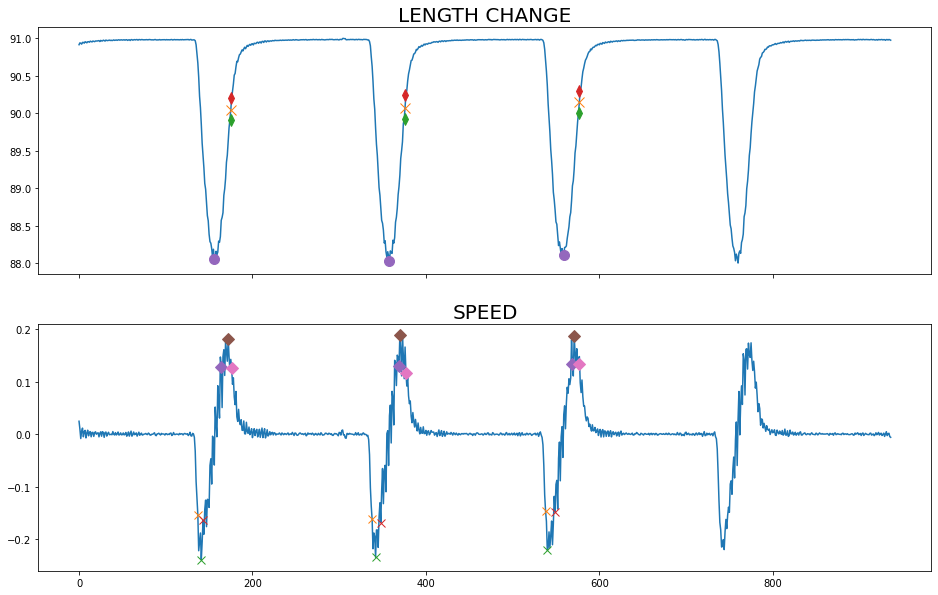

In [31]:
draw_trace(length, speed, As,Bs,Cs,Ds,Es,Js,Is)